# Ensamble methods

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures). In particular, we will make use what we have learned about the [Bootstrap](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/bootstrap_in_finance.ipynb).


## Introduction

The [Bootstrap](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/bootstrap_in_finance.ipynb) is used in many situations in which it is hard or even impossible to directly compute the standard deviation of a quantity of interest. However, it is an extremely powerful tool for prediction as well.

Often time, prediction methods suffer from high variance and low accuracy. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. **Bootstrap aggregation**, or **bagging**, is a general-purpose procedure for reducing the bagging variance of a statistical learning method. It is particularly useful and frequently used in the context of [decision trees](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/tree_based_methods_in_fx.ipynb).

Let's get started by importing a few things and get right away to an example.

### FX trading example

Here we will use the example of FX trading to illustrate how to use bagging for predictions. We have discussed previously the three main types of signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). So, let's start by getting the data on these three types of signals.

For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

We also discussed how to construct [FX trackers](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/creating_fx_time_series_fh.ipynb) for each currency against the USD. Here, we will just upload the data on the FX trackers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneGroupOut

carry_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='carry',index_col=0)
print('carry data has %s currencies and %s dates' % (carry_df.shape[1],carry_df.shape[0]))
mom_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='momentum',index_col=0)
print('momentum data has %s currencies and %s dates' % (mom_df.shape[1],mom_df.shape[0]))
value_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='value',index_col=0)
print('value data has %s currencies and %s dates' % (value_df.shape[1],value_df.shape[0]))
trackers_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='trackers',index_col=0)
print('trackers data has %s currencies and %s dates' % (trackers_df.shape[1],trackers_df.shape[0]))

carry data has 24 currencies and 4973 dates
momentum data has 24 currencies and 4968 dates
value data has 24 currencies and 4973 dates
trackers data has 24 currencies and 5220 dates


The variable we want to predict is
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period. This assumes that we traded at level $I_{t}$ at inception and closed the position $I_{t+h}$. Let's use `Pandas` to create a dataframe containing these returns for $h=21$ business days:

In [2]:
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

returns data has 24 currencies and 2241 dates


## Pooling the data

Let's start by poolling the data. That is we create a set of variables we want to predict:

$$
y_{i,t} = r_{i,t+h}
$$

and a $3 \times 1$ vector of signals containing the signals for currency $i$ at time $t$, $X_{i,t} = [x_{carry,i,t},x_{momentum,i,t},x_{value,i,t}]'$. This vector $X_{i,t}$ will be used to predict the future returns $y_{i,t} = r_{i,t+h}$.

In [3]:
group_dict = dict(zip([ccy for ccy in returns_df.columns],range(len(returns_df.columns))))
groups = pd.DataFrame()
pooled_data = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = returns_df[ccy].to_frame('returns')
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_mom = mom_df[ccy].dropna().to_frame('mom')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_mom,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    
    Z = (X-X.shift(1).ewm(halflife=63).mean())/X.shift(1).ewm(halflife=63).std()
    # make sure the dates of the signals and future returns line up
    yZ = pd.concat([y,Z],axis=1,sort=True).dropna()
    
    pooled_data = pooled_data.append(yZ)
    
    group = pd.DataFrame(index=yZ.index,columns=['group'],data=group_dict[ccy])
    groups = groups.append(group)

Instead of only using the three signals, $[x_{carry,i,t},x_{momentum,i,t},x_{value,i,t}]'$ for prediction, let's also use their interactions and squares:

In [4]:
X = PolynomialFeatures()
X.fit_transform(pooled_data.iloc[:,1:])
features_names = X.get_feature_names(pooled_data.columns[1:])
X = X.fit_transform(pooled_data.iloc[:,1:])
X = pd.DataFrame(index=pooled_data.index,data=X,columns=features_names)
X.head()

,1,carry,mom,value,carry^2,carry mom,carry value,mom^2,mom value,value^2
2011-01-18,1.0,1.217493,-0.215423,-0.511210,1.482290,-0.262276,-0.622394,0.046407,0.110126,0.261335
2011-01-19,1.0,0.854565,-0.174336,-0.595210,0.730281,-0.148982,-0.508645,0.030393,0.103767,0.354275
2011-01-20,1.0,0.565515,-0.402217,-0.304515,0.319807,-0.227460,-0.172208,0.161779,0.122481,0.092729
2011-01-21,1.0,0.570330,-0.461571,-0.407267,0.325276,-0.263248,-0.232276,0.213048,0.187983,0.165866
2011-01-24,1.0,0.909194,-0.302033,-0.515772,0.826633,-0.274606,-0.468936,0.091224,0.155780,0.266020


So, now we predicting future returns $y_{i,t} = r_{i,t+h}$ with the  $X_{i,t}$ but using a second-order polinomial instad of simply using a simple linear function.

### Current state

Suppose I observe the following vector $X_{i,T}$:

In [5]:
c_signal = -0.268358
m_signal = -0.112417
v_signal = 0.212429
X0 = PolynomialFeatures()
X0 = X0.fit_transform([[c_signal,m_signal,v_signal]])
X0

array([[ 1.        , -0.268358  , -0.112417  ,  0.212429  ,  0.07201602,
         0.030168  , -0.05700702,  0.01263758, -0.02388063,  0.04512608]])

### Predicting with a Support Vector Classifier

Support vector classifiers (SVC) is a popular technique for classification. SVCs have been shown to perform well in a variety of settings, and are often considered one of the best “out of the box” classifiers. SVC performs particularly well relative to other methods when we have high dimensional spaces. SVCs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. A good discusion on SVM can be found in Chapter 9 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/).  Let's use the [support vector machines package in scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-classification) to carry out the SVC predictions as we have discussed in our [previous lecture](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/classifiers_fx_example.ipynb).

In [6]:
clf = svm.SVC()
y = np.sign(pooled_data.iloc[:,0])
clf.fit(X,y)
clf.predict([X0.squeeze()])[0]

-1.0

Using the full sample, the SVC is predicting a bear (-1) market in the currency $i$ if its current features are given by the vector $X_{i,T}$.

### Predicting with a Decision Tree

As we have discussed in a [previous lecture](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/tree_based_methods_in_fx.ipynb), similarly to SVCs, decision trees are constructed by stratifying or segmenting the predictor space into a number of simple regions. In order to make a prediction for a given observation, we typically use the mean or the mode of the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as decision tree methods Tand are simple and useful for interpretation.

In [7]:
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X, y)
tree_clf.predict([X0.squeeze()])[0]

-1.0

Using the full sample, the Decision Tree is also predicting a bear (-1) market in the currency $i$ if its current features are given by the vector $X_{i,T}$.

## Bagging

We have seen leave-one-out cross-validation (LOOCV) in a [previous lecture](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/cross_validation_in_fx.ipynb). Here, we use it to create $N=24$ (as many as we have currencies) training sets. Each learning set is created by taking all the markets except one, the test set being the market left out. After the entire process, we will have trained $N$ models, as many models as there are markets or currencies.

For each training set we will a prediction for future returns $\hat{y}_{k,T}$ of currency $i$ given the features vector $X_{i,T}$, one for each trainning set $k$. **Bagging** or **Bootstrap aggregation** consists in taking the average prediction across the different training sets:

$$
\hat{y}_{bag,T} = N^{-1}\sum_{k=1}^{N}\hat{y}_{k,T}
$$

There are three main advantages of using bagging for forecasting:

1. In practice, we know that it greatly improves prediction accuracy of a statistical learning method. Bagging has been demonstrated to give impressive improvements in accuracy, particularly for decision trees, by combining together hundreds or even thousands of predictions into a single procedure.
2. Averaging a set of predictions reduces variance of the predictions so the predictions are more stable across different samples, in particular, the predictions do not completly change as new information becomes available
3. Instead of running a model in the full sample, since we are running the model in several independent samples, we can run each bootstrap prediction in parallel, in a seperate CPU using [multiprocessing](https://docs.python.org/2/library/multiprocessing.html).

In [8]:
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups)
results_df = pd.DataFrame()
for train_index, test_index in logo.split(X, y, groups.iloc[:,0]):
    
    group_results = pd.Series(index=['SVC_prediction','SVC_groups_acc','Tree_prediction','Tree_groups_acc'],data=0.)
    
    clf.fit(X.iloc[train_index],y.iloc[train_index])
    group_results['SVC_prediction'] = clf.predict([X0.squeeze()])[0]
    group_results['SVC_groups_acc'] = (1*(clf.predict(X.iloc[test_index])==y.iloc[test_index])).mean()
                                
    tree_clf = tree_clf.fit(X.iloc[train_index], y.iloc[train_index])
    group_results['Tree_prediction'] = tree_clf.predict([X0.squeeze()])[0]    
    group_results['Tree_groups_acc'] = (1*(tree_clf.predict(X.iloc[test_index])==y.iloc[test_index])).mean()
                                           
    results_df = results_df.append(group_results.to_frame(groups.iloc[test_index[0],0]).T)                                       

Note that now we have two predictions for each trainning set $k$. One prediction $\hat{y}_{k,T}$ coming from the SVC model and another $\tilde{y}_{k,T}$ coming from the decision tree model. We also have how they performed in terms of accuracy in the validation set.

In [9]:
results_df

,SVC_prediction,SVC_groups_acc,Tree_prediction,Tree_groups_acc
0,-1.0,0.553324,-1.0,0.516287
1,-1.0,0.555109,-1.0,0.543507
2,-1.0,0.496653,-1.0,0.495761
3,-1.0,0.499777,-1.0,0.541276
4,-1.0,0.551986,-1.0,0.521196
5,-1.0,0.531958,-1.0,0.589331
6,-1.0,0.562695,-1.0,0.566265
7,-1.0,0.572959,-1.0,0.565373
8,-1.0,0.603748,-1.0,0.635877
9,-1.0,0.532352,-1.0,0.526551


In [10]:
print('This is the simple bagging prediction with SVC: %s' % results_df['SVC_prediction'].mean())
print('This is the simple bagging prediction with DT: %s' % results_df['Tree_prediction'].mean())
acc_weights = results_df['SVC_groups_acc']/results_df['SVC_groups_acc'].sum()
weighted_SVC = results_df['SVC_prediction']*acc_weights
print('This is the weighted bagging prediction with SVC: %s' % weighted_SVC.sum())
acc_weights = results_df['Tree_groups_acc']/results_df['Tree_groups_acc'].sum()
weighted_tree = results_df['Tree_prediction']*acc_weights
print('This is the weighted bagging prediction with Tree: %s' % weighted_tree.sum())
model_combination = (weighted_SVC+weighted_tree)/2
print('This is the weighted bagging prediction with Tree + SVC combined: %s' % model_combination.sum())

This is the simple bagging prediction with SVC: -1.0
This is the simple bagging prediction with DT: -1.0
This is the weighted bagging prediction with SVC: -0.9999999999999999
This is the weighted bagging prediction with Tree: -1.0
This is the weighted bagging prediction with Tree + SVC combined: -1.0


The results above are not exactly predictions, they are averages of -1 and 1 predictions. So, to predict a quantitative outcome for $y_{i,T} = r_{i,T+h}$ we typically take a **majority vote** approach by making the overall prediction is the most commonly occurring majority class among the predictions. In our case, this would be a bull market (1) if the bagging prediction was positive and a bear market (-1) if the bagging prediction was negative.

## Boosting

The main differece between bagging and boosting is that boosting is sequential. While we start with one model for prediction in the first train set, we will fit the model in the second train set taking into account what we have learned in the previous train set. The second model will try to correct the mistakes of the previous model.

Boosting is particularly important in tree based methods making them popular in all kinds of data science problems after successfull performance in [forecasting competitions](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470996430.ch15) such as the [M3-Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions) and more recently on [Kaggle competitions](https://www.kaggle.com/competitions). These very succesfull algorithms, such as the [XGBoost](https://syncedreview.com/2017/10/22/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition/) which we will cover in a [future lecture](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/momentum_with_regression_trees.ipynb) use resampling methods such as the ones we discussed in [previous lectures](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/cross_validation_in_fx.ipynb) to combine a large number of decision trees, resulting in great in prediction accuracy.

Here, we describe one simple boosting methods for classifiers, [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost). [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

#### AdaBoost

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights to each of the training samples. Initially, those weights are all set uniformly so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

Using AdaBoost in the full sample is simple like any other classifier:

In [12]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.5,algorithm="SAMME.R")
ada_clf.fit(X, y)
ada_clf.predict([X0.squeeze()])[0]

-1.0

Now let's see how each of the AdaBoost predictions do out of sample using the LOOCV method. Each learning set is created by taking all the markets except one, the test set being the market left out. After the entire process, we will have trained $N$ AdaBoost classifiers, as many classifiers as there are markets or currencies.

In [16]:
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups)
adaboost_results_df = pd.DataFrame()
for train_index, test_index in logo.split(X, y, groups.iloc[:,0]):    
    group_results = pd.Series(index=['AdaBoost_prediction','AdaBoost_groups_acc'],data=0.)
    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.5,algorithm="SAMME.R")
    ada_clf = ada_clf.fit(X.iloc[train_index],y.iloc[train_index])    
    
    group_results['AdaBoost_prediction'] = ada_clf.predict([X0.squeeze()])[0]
    group_results['AdaBoost_groups_acc'] = (1*(ada_clf.predict(X.iloc[test_index])==y.iloc[test_index])).mean()
    
    adaboost_results_df = adaboost_results_df.append(group_results.to_frame(groups.iloc[test_index[0],0]).T)     

In [17]:
adaboost_results_df

,AdaBoost_prediction,AdaBoost_groups_acc
0,-1.0,0.533690
1,-1.0,0.547077
2,-1.0,0.488621
3,-1.0,0.495761
4,-1.0,0.534583
5,-1.0,0.557121
6,-1.0,0.544846
7,-1.0,0.567158
8,-1.0,0.593039
9,-1.0,0.514056


## Feature Importance

One of the problems with these tree-based methods, particularly when using bagging or boosting is that we lack a bit of interpretation on the importance of each regressor or feature in the predictive model. Let’s start with decision trees to build some intuition. In decision trees, every node is a condition of how to split values in a single feature, so that similar values of the dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity/information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity.

Let's use the method `feature_importances_` in `Scikit-Learn` to implement that logic:

In [18]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,learning_rate=0.5,algorithm="SAMME.R")
ada_clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

Text(0.5, 1.0, 'Feature Importance on AdaBoost')

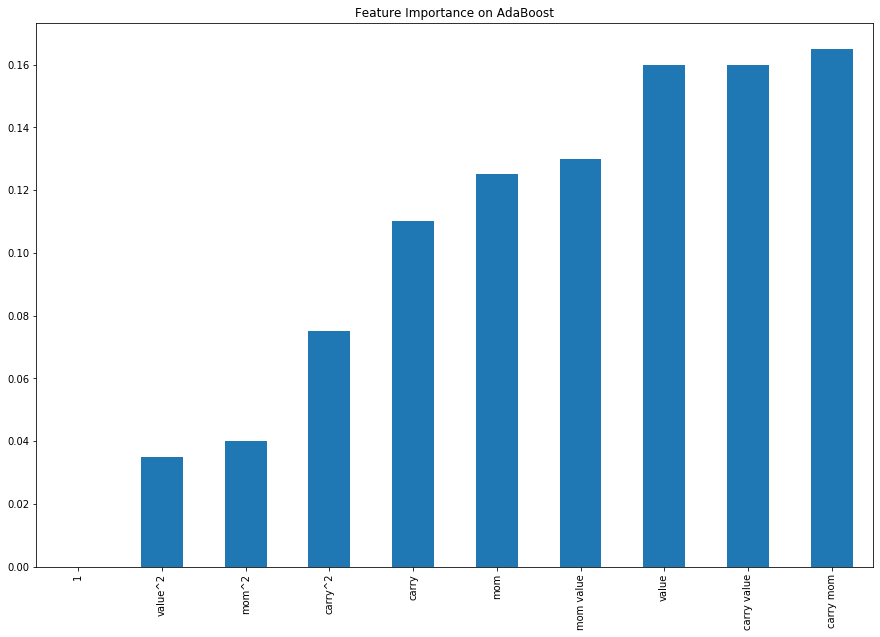

In [21]:
plt.figure(figsize=(15,10))
pd.Series(index=X.columns,data=ada_clf.feature_importances_).sort_values().plot(kind='bar')
plt.title('Feature Importance on AdaBoost')
plt.show()